<a href="https://colab.research.google.com/github/anandsahadevan/COVID19india_visualize/blob/master/SEIR_SIR_Epidemic_Model_Prediction_India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COVID19-India Epidemic Model based Predictions and Visualization**

SEIR  MODEL Reference:
https://www.kaggle.com/anjum48/seir-model-with-intervention
*https://en.wikipedia.org/wiki/mpartmental_models_in_epidemiology#The_SEIR_model
*SEIR Great APP : http://gabgoh.github.io/COVID/index.html
*https://www.kaggle.com/super13579/covid-19-global-forecast-seir-visualize


SIR Model Reference: https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions#section2


For Visualization of Indian Data pls visit: https://medium.com/@toanandss/data-visualization-and-information-extraction-from-covid19india-api-using-python-8a9bff713e7d


---
Notebook features
*   Organize Indian data similar to the COVID19-Kaggle competition data format (https://www.kaggle.com/c/covid19-global-forecasting-week-2)
*   Best Kaggle models can be tested on Indian stat-wise datasets 
*   SEIR Model based General Epidemic Trend visualization
*   SIR Model based General Epidemic Trend visualization
*   SIR and SEIR based Predictions
*   Prepare Indian data for other ensemble models framework

#*** Tune the model parameters for optimum results (varies for different states)

 *pls set the Day0 and Day_n in the first block of the code** 
---

In [71]:
import pandas as pd
import warnings
import json
import requests
import numpy as np
import datetime
from datetime import timedelta
from pathlib import Path
from datetime import date as datefun
from datetime import timedelta
from scipy.integrate import solve_ivp
import seaborn as sb
import matplotlib.pyplot as plt
# import tqdm as tqdm
# from google.colab import drive
# drive.mount('/content/drive/')
from scipy import integrate, optimize


#---------- Set the Day_0 and Day_n and calculate the duration-----------#
day0='2020-03-01'; till_date='2020-04-12'
tot_days=(datefun.today()-datetime.datetime.strptime(day0, '%Y-%m-%d').date()).days
print(tot_days)

#------ Setup the Figure rcParameters------------------------------------#
sb.set_style("whitegrid")
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.dpi'] = 200

43


# **SEIR Model**
# SEIR (Susceptible → Exposed → Infected → Removed)
![picture](https://drive.google.com/uc?id=1Aj9j_DeSe62T-_oKjo_iEbshupfuGy0X)

Source: https://en.wikipedia.org/w/index.php?title=Compartmental_models_in_epidemiology&action=edit&section=13

In [0]:
#-------- SEIR Model -------------------------

def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I

def SEIR_model(t, y, R_t, T_inf, T_inc):
    if callable(R_t):
        reproduction = R_t(t)
    else:
        reproduction = R_t
    S, E, I, R = y
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)
    return [S_out, E_out, I_out, R_out]

#**Understanding SEIR Model, Plot SEIR Model With and Without Intervention** 

SEIR parameters may vary for different regions. 
pls see CDC report: https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article

*SEIR parameters are explained in this site- http://gabgoh.github.io/COVID/index.html

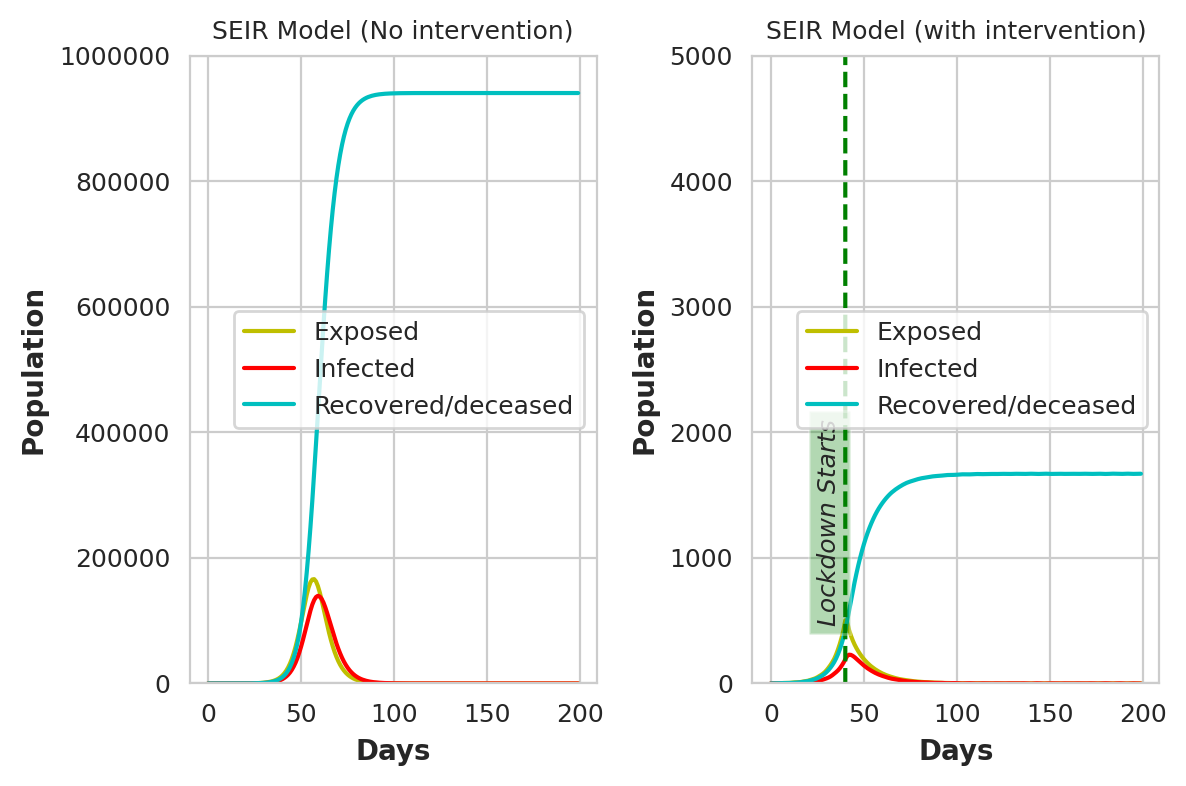

In [36]:
def plot_model(solution, N,maxval, title='SEIR model',intervention_day=None):
    sus, exp, inf, rec = solution.y
#    f = plt.figure(figsize=(8,5)) 
    # plt.plot(sus*N, 'b', label='Susceptible');
    plt.plot(exp*N, 'y', label='Exposed');
    plt.plot(inf*N, 'r', label='Infected');
    plt.plot(rec*N, 'c', label='Recovered/deceased');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.ylabel("Population", fontsize=10);
    plt.legend(loc='best');
    plt.ylim([0,maxval])
    plt.ticklabel_format(useOffset=False, style='plain')
    if intervention_day:
      plt.plot(np.ones((N))*intervention_day,np.arange(0,N),'g--')
      plt.text(intervention_day-15, maxval/10,'Lockdown Starts', style='italic',rotation=90, bbox={'facecolor': 'green', 'alpha': 0.3, 'pad': 3})


''' Model Without Intervention'''
N = 1000000 # Population size
n_infected = 1
max_days = 200

# State at time = 0 for SEIR model
s = (N - n_infected)/ N
e = 0
i = n_infected / N
r = 0

T_inc = 3.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 3  # reproduction number
R_t= 0
sol1 = solve_ivp(fun=lambda t,y:SEIR_model(t, y, R_0, T_inf, T_inc),t_span=[0, max_days],y0=[s,e,i,r], t_eval=np.arange(max_days))


''' Model with Intervention'''
N = 1000000 # Population size
n_infected = 1
max_days = 200
T_inc = 5.2  # average incubation period
T_inf = 2.9  # average infectious period
R_0 = 2.6  # reproduction number without intervention
R_t = 0.4 # reproduction number after intervention
intervention_day = 40  # Intervention Day from Day0

# Constant decay-------------------# Decide the Decay function
def time_varying_reproduction(t):
    if t > intervention_day:
        return R_t
    else:
        return R_0

# Hill Decay function ------------# Decide the Decay function
# L=50
# k=3      #For Hill decay k=2, 
# def time_varying_reproduction(t): 
#     return R_0 / (1 + (t/L)**k)


sol2 = solve_ivp(fun=lambda t,y:SEIR_model(t, y, time_varying_reproduction(t), T_inf, T_inc),t_span=[0, max_days],y0=[s,e,i,r], t_eval=np.arange(max_days))

plt.subplot(1,2,1)
plot_model(sol1,N,N,'SEIR Model (No intervention)',None)
plt.subplot(1,2,2)
plot_model(sol2,N,N*.005,'SEIR Model (with intervention)',intervention_day)
plt.tight_layout()

#**SIR Model**


In [0]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

# Plot SIR model response

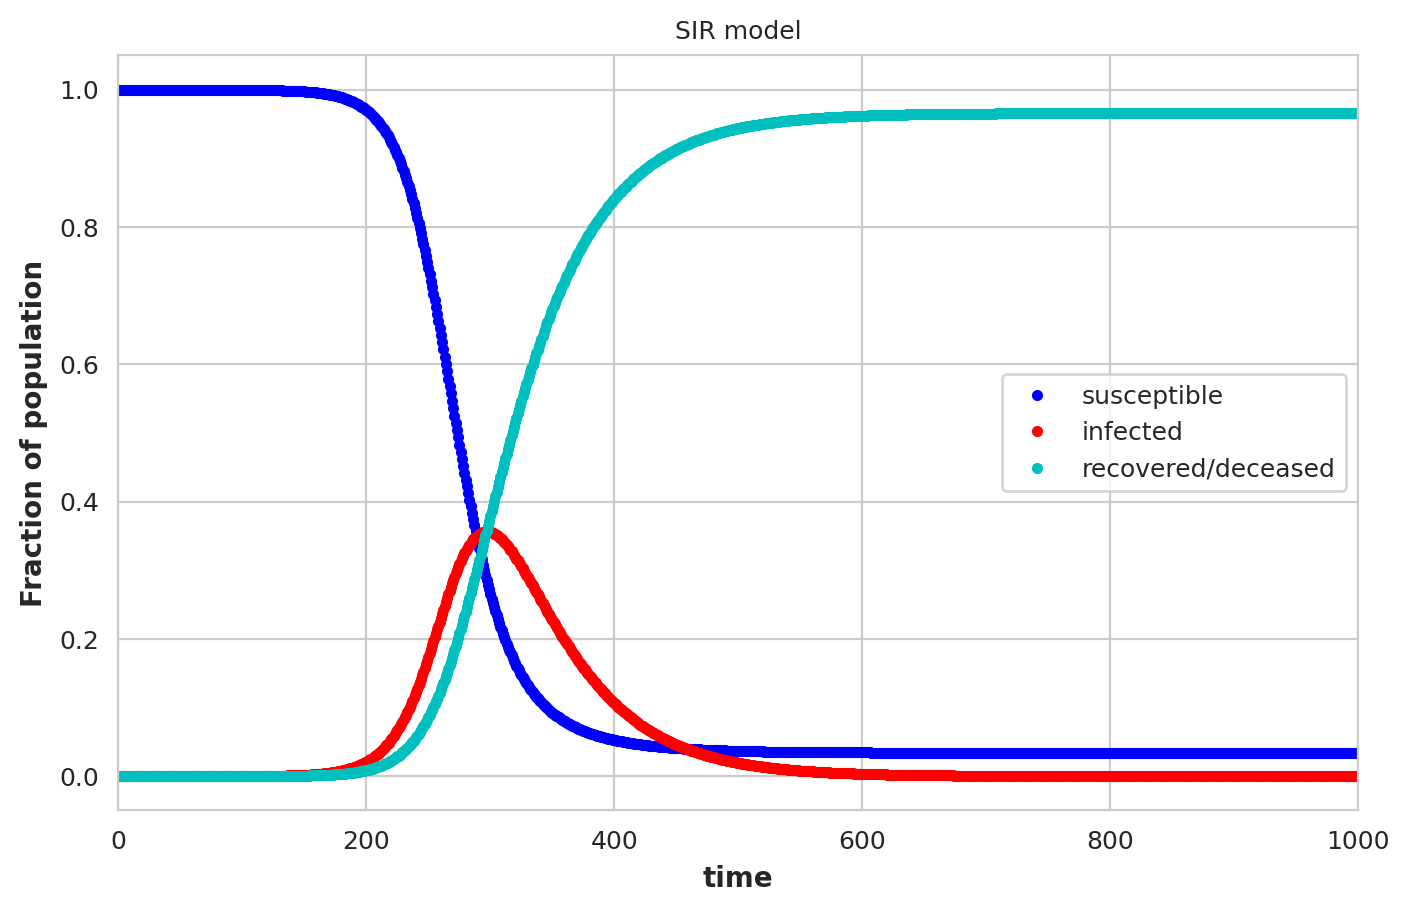

In [38]:
# Parameters of the model
N = 1000000 # No. of population
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

# Following scripts pull data from API, Plot, Predict using SEIR/SIR model
### **The following code will read the data from https://api.covid19india.org/**



In [0]:
data_raw=requests.get('https://api.covid19india.org/raw_data.json').json()  # read API
head=list(data_raw['raw_data'][0].keys())

temp = pd.DataFrame([]) 
for i in range(0,len(data_raw['raw_data'])):
   data1=pd.DataFrame([data_raw['raw_data'][i].values()], columns=head)
   temp=temp.append(data1,ignore_index = True)

#------------  Remove No data rows ------------------------------------
temp1= list(temp.loc[0:len(data_raw['raw_data']),'currentstatus'])
valid_data=[i for i, item in enumerate(temp1) if item != '']
data_raw=temp[0:len(valid_data)]

### Following code keeps the date format similar to the format of Kaggle Competition (https://www.kaggle.com/c/covid19-global-forecasting-week-2)   

In [0]:
temp_data=data_raw.copy()
temp1= list(data_raw.loc[:,'dateannounced'])
DATE = [datetime.datetime.strptime(x,'%d/%m/%Y') for x in temp1]
temp_data.loc[:,'dateannounced'] = DATE

temp2= pd.to_datetime(temp_data.dateannounced,format='%Y-%m-%d')
temp_data.loc[:,'dateannounced'] = temp2.dt.strftime('%Y-%m-%d')


# #---------Set till-date as the Last date available in data_raw-------
yesterday = datefun.today() - timedelta(days=1)
date_yesterday=yesterday.strftime('%Y-%m-%d')
date_yesterday=till_date

data_temp = temp_data[(temp_data['dateannounced'] <= date_yesterday)]

## Following codes prepare Statewise Data for

* Updating the dataframe with Columns such as 'ConfirmedCases', 'Fatalities', 'Days', 'Date' etc. etc.
* Data can be reorganised based on the date of 'day0', this will enable the comparison of trends at differend time scale. (change the day0 date at the first line)
* This approach manages missing dates in the initial months
* Cumulative Sum (Statwise)
* Visualization

#*Save data as "csv" file

In [41]:
data=data_temp
data.loc[:,'Confirmed']=np.ones((data_temp['dateannounced'].size),dtype='int')
data.loc[:,'Recovered'] = np.zeros((data_temp['dateannounced'].size),dtype='int')
temp=data[data['currentstatus']=='Recovered']
data.loc[list(temp.index),'Recovered']=1
data.loc[:,'Fatalities'] = np.zeros((data_temp['dateannounced'].size),dtype='int')
temp=data[data['currentstatus']=='Fatalities']
data.loc[list(temp.index),'Fatalities']=1

data=data.rename({'detectedstate': 'State'}, axis='columns')
data=data.rename({'dateannounced': 'Date'}, axis='columns')

temp_data=data.copy()
temp2= pd.to_datetime(temp_data.Date,format='%Y-%m-%d')
data.loc[:,'Date'] = temp2.dt.strftime('%Y-%m-%d')


''' Prepare State Data '''
States=list(data.State.unique())
final_data=pd.DataFrame([])
for j in range (0,len(States)):
    st= data.query('State == '+ '"'+States[j]+'"')
    #a=st['Confirmed'].cumsum()
    date=list(st.Date.unique())
    a=list(pd.date_range(start=day0, end=till_date).date)#date[len(date)-1]).date)
    dat1=dict()
    dat2=dict()
    for i in a:
        dt=st["Date"] == str(i)
        aa=st.loc[dt].Confirmed.sum()
        bb=st.loc[dt].Fatalities.sum()
        dat1[i]=aa
        dat2[i]=bb
    datc=np.array(list(dat1.values())).cumsum()
    datf=np.array(list(dat2.values())).cumsum()
    nam=pd.Series([States[j]])
    name=nam.repeat(len(a))
    days=np.arange(len(a))
    tempdata={'State':name,'Date': pd.to_datetime(a,format='%Y-%m-%d'),'Day':days,'ConfirmedCases': datc.T,'Fatalities': datf.T,}
    dd=pd.DataFrame.from_dict(tempdata)
    final_data=final_data.append(dd,ignore_index = True)

temp1= pd.to_datetime(final_data.Date)
final_data['Date'] = temp1.dt.strftime('%Y-%m-%d')


#'''Save statewise data as CSV'''
##final_data.to_csv (r'C:/Users/Anand/Desktop/covid/covid_data_python_gen2.csv', index = False, header=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
print(final_data)

         State        Date  Day  ConfirmedCases  Fatalities
0       Kerala  2020-03-01    0               0           0
1       Kerala  2020-03-02    1               0           0
2       Kerala  2020-03-03    2               0           0
3       Kerala  2020-03-04    3               0           0
4       Kerala  2020-03-05    4               0           0
...        ...         ...  ...             ...         ...
1457  Nagaland  2020-04-08   38               0           0
1458  Nagaland  2020-04-09   39               0           0
1459  Nagaland  2020-04-10   40               0           0
1460  Nagaland  2020-04-11   41               0           0
1461  Nagaland  2020-04-12   42               1           0

[1462 rows x 5 columns]


# **National Trend in India**
* Visualization

Text(24, 9700, 'Intensive-Test Starts')

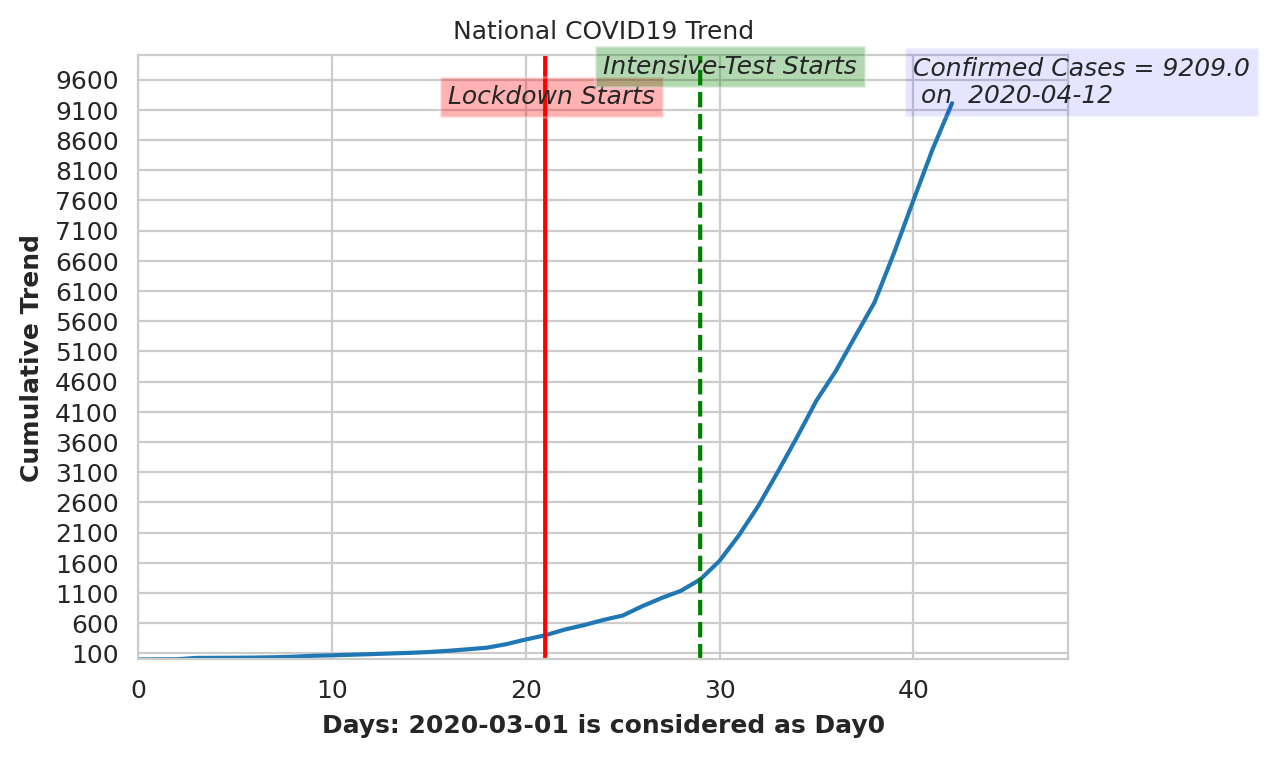

In [43]:
max_cases=10000
xloc=40

trainn=final_data.copy()
States=list(trainn.State.unique())
confcase=np.zeros((tot_days,len(States)))
for j in range (0,len(States)):
    tt= trainn.query('State == '+ '"'+States[j]+'"')
    confcase[:,j]=tt.ConfirmedCases
tot_cases=confcase.sum(axis=1)
plt.plot(np.arange(0,tot_days),confcase.sum(axis=1))
plt.xlabel('Days: '+ str(day0) +' is considered as Day0')
plt.ylabel('Cumulative Trend')
plt.xticks(np.arange(0,tot_days+5,10))
plt.xlim([0,tot_days+5]);plt.ylim([0,max_cases])
plt.yticks(np.arange(100,max_cases,500))
plt.text(xloc, tot_cases[-1], 'Confirmed Cases' +" = "+ str(tot_cases[-1])+ '\n on  ' + str(till_date), style='italic',bbox={'facecolor':'blue', 'alpha': 0.1, 'pad': 3})
plt.title('National COVID19 Trend')
rangey=np.arange(0,max_cases)
lockday=(datetime.datetime.strptime('2020-03-22', '%Y-%m-%d').date()-datetime.datetime.strptime(day0, '%Y-%m-%d').date()).days
intens_day=(datetime.datetime.strptime('2020-03-30', '%Y-%m-%d').date()-datetime.datetime.strptime(day0, '%Y-%m-%d').date()).days
plt.plot(np.ones((rangey.size))*lockday,np.arange(0,max_cases),'r',label='Lockdown_day')
plt.text(lockday-5, max_cases-800,'Lockdown Starts', style='italic',bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 3})
plt.plot(np.ones((rangey.size))*intens_day,np.arange(0,max_cases),'g--',label='Intensive-Test Starts')
plt.text(intens_day-5, max_cases-300,'Intensive-Test Starts', style='italic',bbox={'facecolor': 'green', 'alpha': 0.3, 'pad': 3})

# Visualization of State-wise trends
 **Plot the trends of Highly affected states till date**
##Linear Trend

Text(24, 2700, 'Intensive-Test Starts')

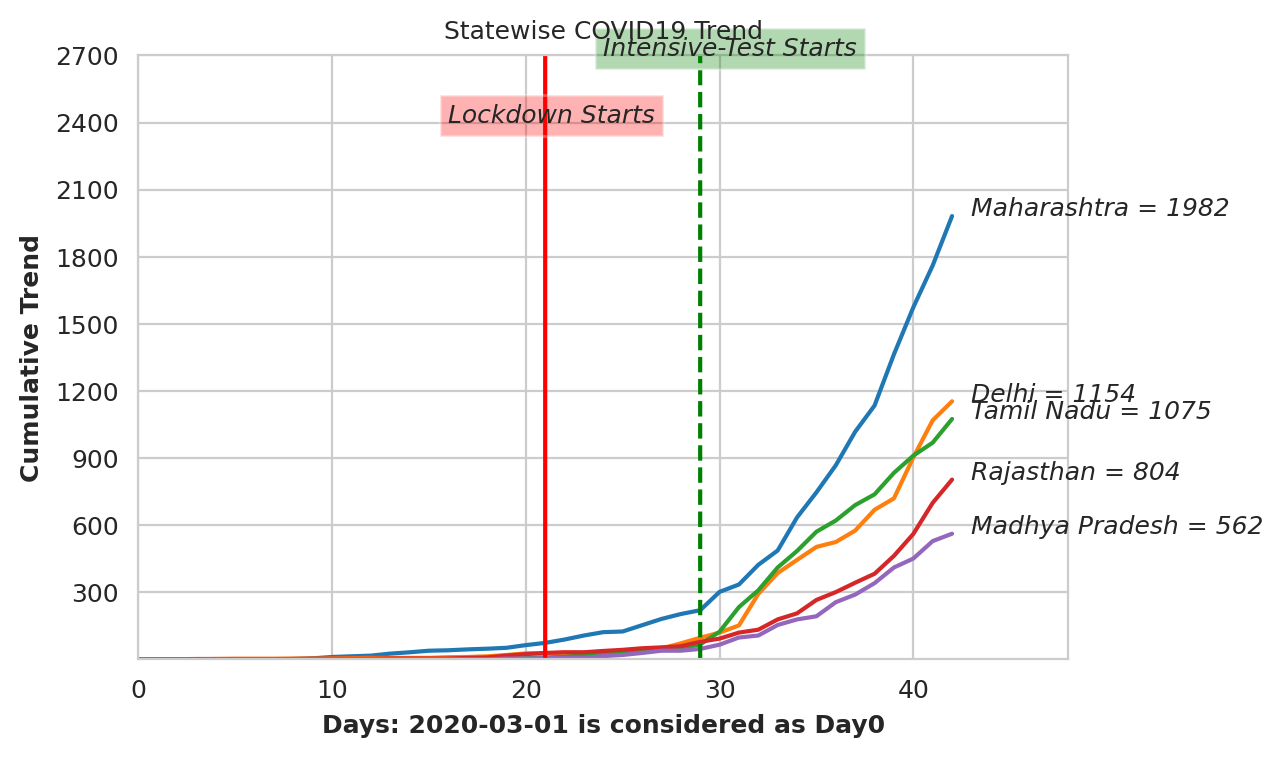

In [44]:
no_states=5       #provide the no. of highest infected (Descending order)
max_cases=3000
xloc=43
step=300

trains=final_data
States=list(trains.State.unique())
gb=pd.DataFrame(trains.groupby(['State'])['ConfirmedCases'].agg('max'))
stsort=gb.sort_values(by=['ConfirmedCases'],ascending=False)

for j in range (0,no_states):
    tt= trains.query('State == '+ '"'+stsort.index[j]+'"')
    tss=tt.ConfirmedCases
    days=(tt.Day)
    plt.plot(days,(tss))
#    plt.legend()
    plt.xlabel('Days: '+ str(day0) +' is considered as Day0')
    plt.ylabel('Cumulative Trend')
    plt.xticks(np.arange(0,tot_days+5,10))
    plt.xlim([0,tot_days+5]);plt.ylim([0,1200])
    plt.yticks(np.arange(step,max_cases,step))
    plt.text(xloc, tss.iloc[-1], str(stsort.index[j]) +" = "+ str(tss.iloc[-1]), style='italic')#,bbox={'facecolor': 'white', 'alpha': 0.3, 'pad': 3})
    plt.title('Statewise COVID19 Trend')
rangey=np.arange(0,max_cases)
lockday=(datetime.datetime.strptime('2020-03-22', '%Y-%m-%d').date()-datetime.datetime.strptime(day0, '%Y-%m-%d').date()).days
intens_day=(datetime.datetime.strptime('2020-03-30', '%Y-%m-%d').date()-datetime.datetime.strptime(day0, '%Y-%m-%d').date()).days
plt.plot(np.ones((rangey.size))*lockday,np.arange(0,max_cases),'r',label='Lockdown_day')
plt.text(lockday-5, max_cases-600,'Lockdown Starts', style='italic',bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 3})
plt.plot(np.ones((rangey.size))*intens_day,np.arange(0,max_cases),'g--',label='Intensive-Test Starts')
plt.text(intens_day-5, max_cases-300,'Intensive-Test Starts', style='italic',bbox={'facecolor': 'green', 'alpha': 0.3, 'pad': 3})
# plt.legend()

In [45]:
print(stsort.index)

Index(['Maharashtra', 'Delhi', 'Tamil Nadu', 'Rajasthan', 'Madhya Pradesh',
       'Telangana', 'Gujarat', 'Uttar Pradesh', 'Andhra Pradesh', 'Kerala',
       'Jammu and Kashmir', 'Karnataka', 'Haryana', 'Punjab', 'West Bengal',
       'Bihar', 'Odisha', 'Uttarakhand', 'Himachal Pradesh', 'Chhattisgarh',
       'Assam', 'Chandigarh', 'Jharkhand', 'Ladakh',
       'Andaman and Nicobar Islands', 'Puducherry', 'Goa', 'Manipur',
       'Tripura', 'Nagaland', 'Mizoram', 'Dadra and Nagar Haveli',
       'Arunachal Pradesh', ''],
      dtype='object', name='State')


# **Compare the trends of selected states**
**Pls copy the state name from the following list**

['Kerala', 'Delhi', 'Telangana', 'Rajasthan', 'Haryana', 'Uttar Pradesh', 'Ladakh', 'Tamil Nadu', 'Jammu and Kashmir', 'Karnataka', 'Maharashtra', 'Punjab', 'Andhra Pradesh', 'Uttarakhand', 'Odisha', 'Puducherry', 'West Bengal', 'Chandigarh', 'Chhattisgarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh', 'Bihar', 'Manipur', 'Mizoram', 'Goa', 'Andaman and Nicobar Islands', 'Jharkhand', 'Assam', 'Arunachal Pradesh', 'Dadra and Nagar Haveli', 'Tripura']

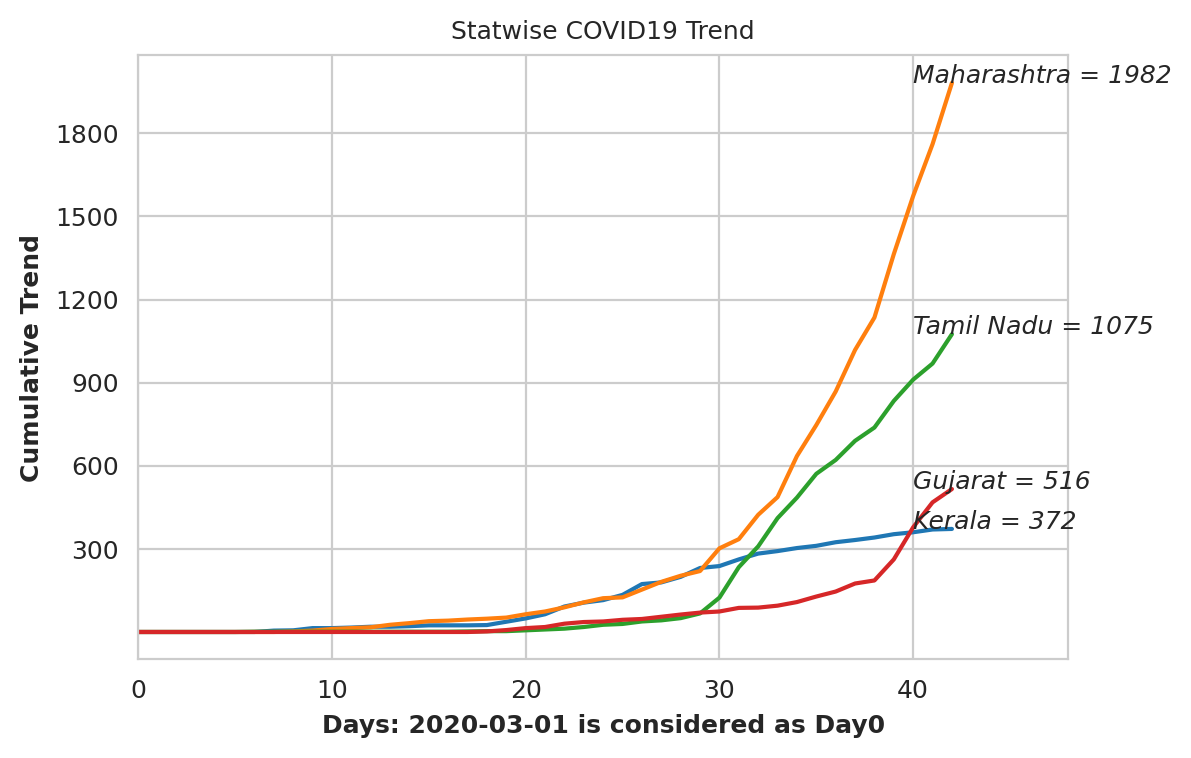

In [46]:
state_name=['Kerala', 'Maharashtra', 'Tamil Nadu', 'Gujarat']
max_cases=2000
xloc=40
step=300

for j in range(0,len(state_name)):
  tt= trains.query('State == '+ '"'+state_name[j]+'"')
  tss=tt.ConfirmedCases
  days=(tt.Day)
  plt.plot(days,(tss))
  # plt.legend()
  plt.xlabel('Days: '+ str(day0) +' is considered as Day0')
  plt.ylabel('Cumulative Trend')
  plt.xticks(np.arange(0,tot_days+5,10));plt.xlim([0,tot_days+5])
  plt.yticks(np.arange(step,max_cases,step))
  plt.text(xloc, tss.iloc[-1], str(state_name[j]) +" = "+ str(tss.iloc[-1]), style='italic')#,bbox={'facecolor': 'white', 'alpha': 0.3, 'pad': 3})
  plt.title('Statwise COVID19 Trend')


In [0]:
pop_info = pd.read_csv('https://raw.githubusercontent.com/anandsahadevan/COVID19india_visualize/master/india_population.csv') #pd.read_csv(pop)
country_pop = pop_info.query('Type == "Province/State"')
country_lookup = dict(zip(country_pop['Name'], country_pop['Population']))

train= final_data
test = final_data
train['Date_datetime'] = train['Date'].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d')))


In [0]:
''' Fit SEIR Model '''

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

def cumsum_signal(vec):
   temp_val = 0
   vec_new = []
   for i in vec:
       if i > temp_val:
           vec_new.append(i)
           temp_val = i
       else:
           vec_new.append(temp_val)
   return vec_new


# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution, forecast_days=0):
   R_0, cfr = params # Paramaters, R0 and cfr 
   N = population # Population of each country
   n_infected = data['ConfirmedCases'].iloc[0] # start from first comfirmedcase on dataset first date
   max_days = len(data) + forecast_days # How many days want to predict
   s, e, i, r = (N - n_infected)/ N, 0, n_infected / N, 0 #Initial stat for SEIR model
   
   # R0 become half after intervention days
   def time_varying_reproduction(t):
       if t > intervention: # we set intervention days = 80
           return R_0 * R_t
       else:
           return R_0
   
   # Solve the SEIR differential equation.
   sol = solve_ivp(fun=lambda t,y:SEIR_model(t, y, time_varying_reproduction(t), T_inf, T_inc),t_span=[0, max_days],y0=[s,e,i,r], t_eval=np.arange(max_days))
   
   sus, exp, inf, rec = sol.y
   # Predict confirmedcase
   y_pred_cases = np.clip((inf + rec) * N ,0,np.inf)
   y_true_cases = data['ConfirmedCases'].values
   
   # Predict Fatalities by remove * fatality rate(cfr)
   y_pred_fat = np.clip(rec*N* cfr, 0, np.inf)
   y_true_fat = data['Fatalities'].values
   
   optim_days = min(20, len(data))  # Days to optimise for
   weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
   
   # using mean squre log error to evaluate
   msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
   msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
   msle_final = np.mean([msle_cases, msle_fat])
   
   if return_solution:
       return msle_final, sol
   else:
       return msle_final

# Use a Hill decayed reproduction number
def eval_model_decay(params, data, population, return_solution, forecast_days):
   R_0, cfr, k, L = params # Paramaters, R0 and cfr 
   N = population # Population of each country
   n_infected = data['ConfirmedCases'].iloc[0] # start from first comfirmedcase on dataset first date
   max_days = len(data) + forecast_days # How many days want to predict
   s, e, i, r = N, 0, 0, 0#(N - n_infected)/ N, 0, n_infected / N, 0 #Initial stat for SEIR model
   
   # https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions   
   # Hill decay. Initial values: R_0=2.2, k=2, L=50
#    R_0, cfr, k, L=[ 2.9 , 0.009593316 , .7      ,   30]
   def time_varying_reproduction(t): 
       return R_0 / (1 + (t/L)**k)
   
   # Solve the SEIR differential equation.
   sol = solve_ivp(fun=lambda t,y:SEIR_model(t, y, time_varying_reproduction(t), T_inf, T_inc),t_span=[0, max_days],y0=[s,e,i,r], t_eval=np.arange(max_days))
   
   sus, exp, inf, rec = sol.y
   # Predict confirmedcase
   y_pred_cases = np.clip((inf + rec) * N ,0,np.inf)
   y_true_cases = data['ConfirmedCases'].values
   
   # Predict Fatalities by remove * fatality rate(cfr)
   y_pred_fat = np.clip(rec*N* cfr, 0, np.inf)
   y_true_fat = data['Fatalities'].values
   
   optim_days = min(20, len(data))  # Days to optimise for
   weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
   
   # using mean squre log error to evaluate
   msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
   msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
   msle_final = np.mean([msle_cases, msle_fat])
   
   if return_solution:
       return msle_final, sol
   else:
       return msle_final


''' Fit Function'''
from matplotlib import dates
import plotly.graph_objects as go
import plotly.express as px

def fit_model_new(data, area_name, initial_guess=[2.9, 0.01, 1, 30], bounds=((1, 8), (0, 0.05), (.5, 5), (1, 100)), make_plot=True, decay_mode = None):
   maxdays=100
   train = data.query('ConfirmedCases > 0').copy()
   
   ####### Split Train & Valid #######
   valid_data = train[-5:]
   train_data = train[:-5]
   
   ####### If this country have no ConfirmedCase, return 0 #######
   if len(train_data) == 0:
       result_zero = np.zeros((43))
       return pd.DataFrame({'ConfirmedCases':result_zero,'Fatalities':result_zero}), 0 
   
   ####### Load the population of area #######
   try:
       population = pop_info[pop_info['Name']==area_name]['Population'].tolist()[0]
   except IndexError:
       print ('State not in population set, '+str(area_name))
       population = 1000000 
   
   cases_per_million = train_data['ConfirmedCases'].max() * 10**6 / population
   n_infected = train_data['ConfirmedCases'].iloc[0]
   
   ####### Total case/popuplation below 1, reduce country population #######
   if cases_per_million < 1:
       #print ('reduce pop divide by 100')
       population = population/100
   
   forecast_days=0;return_solution=False    
   ####### Fit the real data by minimize the MSLE #######
   res_const = minimize(eval_model_const, [2.2, 0.02], bounds=((1, 20), (0, 0.15)),
                        args=(train_data, population,return_solution,forecast_days),
                        method='L-BFGS-B')

   res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                        args=(train_data, population,return_solution,forecast_days),
                        method='L-BFGS-B')
   
   ####### Align the date information #######
   test_end = datetime.datetime.strptime('2020-04-30','%Y-%m-%d')
   test_start = datetime.datetime.strptime('2020-04-10','%Y-%m-%d')
   test_period = (test_end - test_start).days
   train_max = train_data.Date_datetime.max()
   train_min = train_data.Date_datetime.min()
   add_date = 0
   delta_days =(test_end - train_max).days
   train_add_time=[]

   if train_min > test_start:
       add_date = (train_min-test_start).days
       last = train_min-timedelta(add_date)
       train_add_time = np.arange(last, train_min, dtype='datetime64[D]').tolist()
       train_add_time = pd.to_datetime(train_add_time)
       dates_all = train_add_time.append(pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]')))
   else:
       dates_all = pd.to_datetime(np.arange(train_min, test_end+timedelta(1), dtype='datetime64[D]'))


   ####### Auto find the best decay function ####### 
   if decay_mode is None:
       if res_const.fun < res_decay.fun :
           msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days+add_date)
           res = res_const

       else:
           msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days+add_date)
           res = res_decay
           R_0, cfr, k, L = res.x
   else:
       if decay_mode =='day_decay':
           msle, sol = eval_model_const(res_const.x, train_data, population, True, delta_days+add_date)
           res = res_const
       else:
           msle, sol = eval_model_decay(res_decay.x, train_data, population, True, delta_days+add_date)
           res = res_decay
           R_0, cfr, k, L = res.x

   ####### Predict the result by using best fit paramater of SEIR model ####### 
   sus, exp, inf, rec = sol.y
   
   y_pred = pd.DataFrame({'ConfirmedCases': cumsum_signal(np.diff(np.hstack((n_infected,(inf + rec) * population))).cumsum()),
       'Fatalities': cumsum_signal((np.clip(rec * population * res.x[1], 0, np.inf)).tolist())})

   y_pred_valid = y_pred.iloc[len(train_data):len(train_data)+len(valid_data)]
   y_pred_test = y_pred.iloc[-(test_period+1):]
   y_true_valid = valid_data[['ConfirmedCases', 'Fatalities']]
   ####### Calculate MSLE ####### 
   valid_msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid['ConfirmedCases'])
   valid_msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
   valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
   
   ####### Plot the fit result of train data and forecast after 300 days ####### 
   if make_plot:
       if len(res.x)<=2:
           print(f'Validation MSLE: {valid_msle:0.5f}, using intervention days decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}')
       else:
           print(f'Validation MSLE: {valid_msle:0.5f}, using Hill decay, Reproduction number(R0) : {res.x[0]:0.5f}, Fatal rate : {res.x[1]:0.5f}, K : {res.x[2]:0.5f}, L: {res.x[3]:0.5f}')
       
       ####### Plot the fit result of train data dna SEIR model trends #######

       f = plt.figure(figsize=(10,5))
       ax = f.add_subplot(1,2,1)
       ax.plot(exp*population, 'y', label='Exposed');
       ax.plot(inf*population, 'r', label='Infected');
       ax.plot(rec*population, 'c', label='Recovered/deceased');
       plt.title('SEIR Model Trends')
       plt.xlabel("Days", fontsize=10);
       plt.ylabel("Fraction of population", fontsize=10);
       plt.legend(loc='best');
       ax2 = f.add_subplot(1,2,2)
       xaxis = train_data['Date_datetime'].tolist()
       xaxis = dates.date2num(xaxis)
       hfmt = dates.DateFormatter('%m\n%d')
       ax2.xaxis.set_major_formatter(hfmt)
       ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'),train_data['ConfirmedCases'],label='Confirmed Cases (train)', c='g')
       ax2.plot(np.array(train_data['Date_datetime'], dtype='datetime64[D]'), y_pred['ConfirmedCases'][:len(train_data)],label='Cumulative modeled infections', c='r')
       ax2.plot(np.array(valid_data['Date_datetime'], dtype='datetime64[D]'), y_true_valid['ConfirmedCases'],label='Confirmed Cases (valid)', c='b')
       ax2.plot(np.array(valid_data['Date_datetime'], dtype='datetime64[D]'),y_pred_valid['ConfirmedCases'],label='Cumulative modeled infections (valid)', c='y')
       plt.title('Real ConfirmedCase and Predict ConfirmedCase')
       plt.xlabel("Days", fontsize=10);
       plt.ylabel("Population", fontsize=10);
       plt.legend(loc='best');
       plt.legend(loc='best');
       plt.show()
           
       ####### Forecast 300 days after by using the best paramater of train data #######
       if len(res.x)>2:
           msle, sol = eval_model_decay(res.x, train_data, population, True, maxdays)
       else:
           msle, sol = eval_model_const(res.x, train_data, population, True, maxdays)
       
       sus, exp, inf, rec = sol.y
       
       y_pred = pd.DataFrame({
           'ConfirmedCases': cumsum_signal(np.diff(np.hstack((n_infected,(inf + rec) * population))).cumsum()),
           'Fatalities': cumsum_signal(np.clip(rec, 0, np.inf) * population * res.x[1])
       })
       
       ####### Plot 300 days after of each country #######
       start = train_min
       end = start + timedelta(len(y_pred))
       time_array = np.arange(start, end, dtype='datetime64[D]')

       max_day = np.where(inf == np.amax(inf))[0][0]
       where_time = time_array[max_day]
       pred_max_day = y_pred['ConfirmedCases'][max_day]
       xy_show_max_estimation = (where_time, max_day)
       
       con = y_pred['ConfirmedCases']
       max_day_con = np.where(con == np.amax(con))[0][0] # Find the max confimed case of each country
       max_con = np.amax(con)
       where_time_con = time_array[len(time_array)-50]
       xy_show_max_estimation_confirmed = (where_time_con, max_con)
#        
       fig = go.Figure()
       fig.add_trace(go.Scatter(x=time_array, y=y_pred['ConfirmedCases'].astype(int),
                           mode='lines',
                           line = dict(color='red'),
                           name='Estimation Confirmed Case Start from '+ str(start.date())+ ' to ' +str(end.date())))
       fig.add_trace(go.Scatter(x=time_array[:len(train)], y=train['ConfirmedCases'],
                           mode='lines',
                           name='Confirmed case until '+ str(train_max.date()),line = dict(color='green', width=4)))
       fig.add_annotation(
           x=where_time_con,
           y=max_con-(max_con/30),
           showarrow=False,
           text="Estimate Max Case around:" +str(int(max_con)),
           font=dict(
               color="Blue",
               size=15
           ))
       fig.add_annotation(
           x=time_array[len(train)-1],
           y=train['ConfirmedCases'].tolist()[-1],
           showarrow=True,
           text=f"Real Max ConfirmedCase: " +str(int(train['ConfirmedCases'].tolist()[-1]))) 
       
 
       fig.update_layout(title='Estimate Confirmed Case ,'+area_name+' Total population ='+ str(int(population)), legend_orientation="h")
       fig.show()
       
       df = pd.DataFrame({'Values': train_data['ConfirmedCases'].tolist()+y_pred['ConfirmedCases'].tolist(),'Date_datatime':time_array[:len(train_data)].tolist()+time_array.tolist(),
                  'Real/Predict': ['ConfirmedCase' for i in range(len(train_data))]+['PredictCase' for i in range(len(y_pred))]})
       f1 = plt.figure(figsize=(30,5))
       ax3 = f1.add_subplot(1,2,1)
       ax3.plot(time_array[:len(train)], train['ConfirmedCases'],'g',label='Actual COVID Cases')
       ax3.plot(time_array, y_pred['ConfirmedCases'],'r',label='SEIR predicted')
       plt.legend()
       plt.xlabel('Days')
       plt.ylabel('Affected Population')
      #  fig = px.line(df, x="Date_datatime", y="Values",color = 'Real/Predict')
      #  fig.show()
   return y_pred_test, valid_msle

Validation MSLE: 0.00235, using intervention days decay, Reproduction number(R0) : 1.89098, Fatal rate : 0.00000


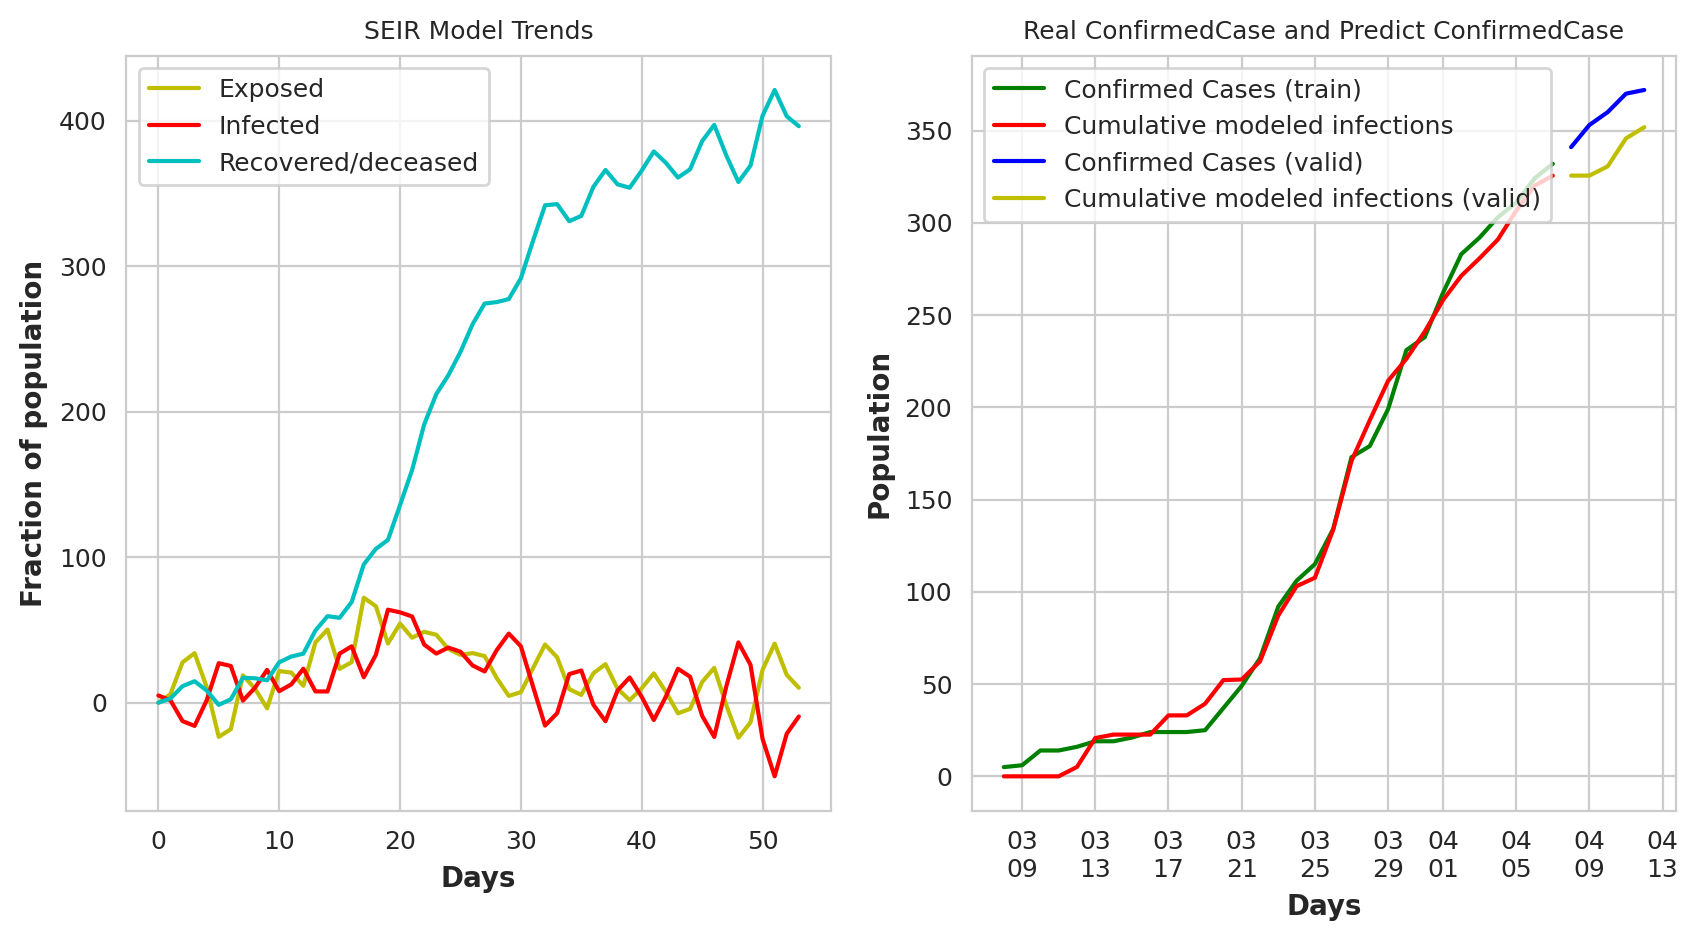

(    ConfirmedCases  Fatalities
 33      330.590038           0
 34      345.757506           0
 35      351.817952           0
 36      351.817952           0
 37      351.817952           0
 38      359.804895           0
 39      366.421455           0
 40      366.421455           0
 41      366.421455           0
 42      370.367944           0
 43      379.405500           0
 44      379.588850           0
 45      379.588850           0
 46      379.588850           0
 47      382.451095           0
 48      394.442920           0
 49      394.442920           0
 50      394.442920           0
 51      394.442920           0
 52      394.442920           0
 53      394.442920           0, 0.0023510267397033715)

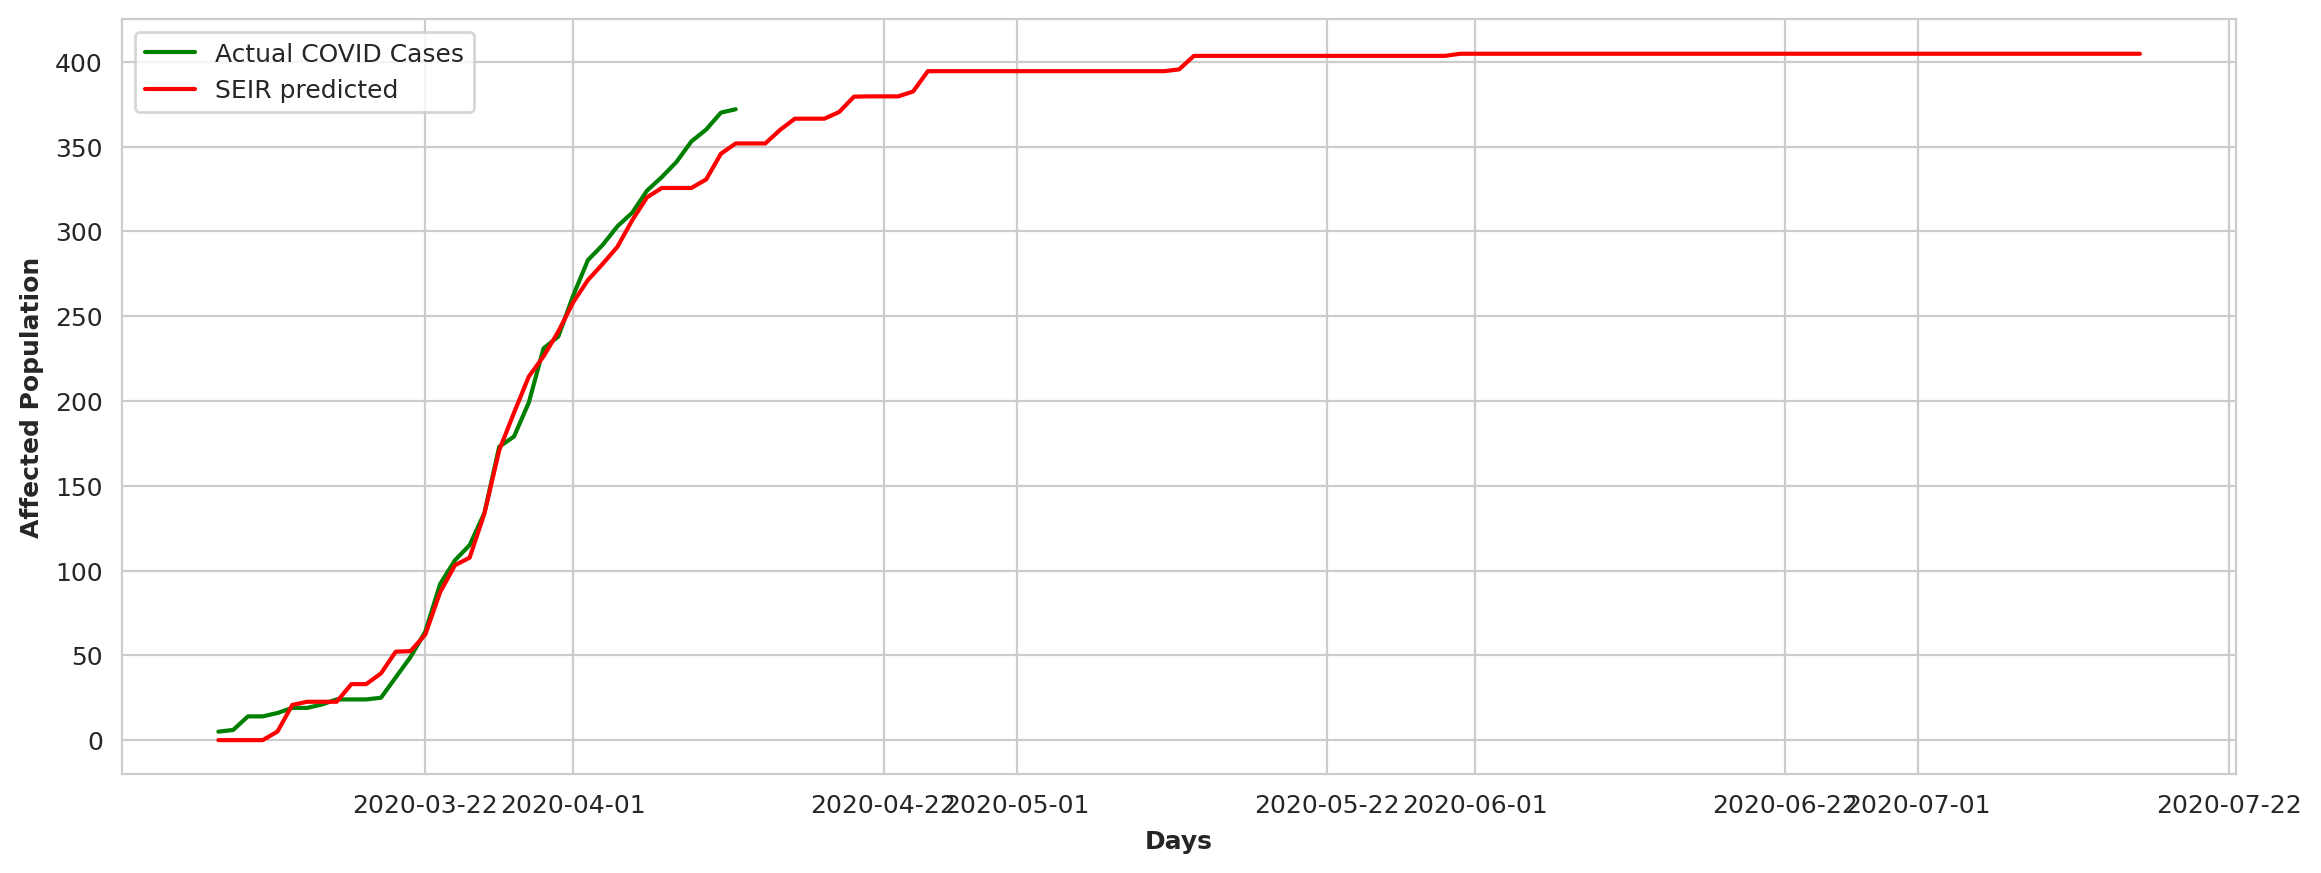

In [91]:
##   Kerala  
state = 'Kerala' 
T_inc = 2.8 # average incubation period Kerala=4
T_inf = 2.1 # average infectious period
R_0 = 3 # reproduction number
R_t = 0.3
intervention=20



# state = 'Maharashtra'
# T_inc = 2.9  # average incubation period Kerala=4
# T_inf = 2.5 # average infectious period
# R_0 = 2 # reproduction number
# R_t = 0.3
# intervention=20

state_pd_train = train[train['State']==state]
state_pd_train2 = state_pd_train.groupby(['Date']).sum().reset_index()
state_pd_train2['Date_datetime'] = state_pd_train2['Date'].apply(lambda x: (datetime.datetime.strptime(x, '%Y-%m-%d')))
fit_model_new(state_pd_train2,state,make_plot=True)       

# SIR predictions
The SIR model is purely theoretical (involve coupled equations relating the number of susceptible people S(t), number of people infected I(t), and number of people who have recovered R(t)), We need to extract the  β  and  γ  paramaters for each case to predict the spread of the virus.
Where,  β  is the contagion rate of the pathogen and  γ  is the recovery rate

Results obtained for N= satate population, for only one initial infected case,  β=0.3 ,  γ=0.5  and a leap pass  hs are shown below:

For more info: 
http://mat.uab.cat/matmat/PDFv2013/v2013n03.pdf

https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions



Optimal parameters: beta = 55.8263356046708  and gamma =  55.55470019210858


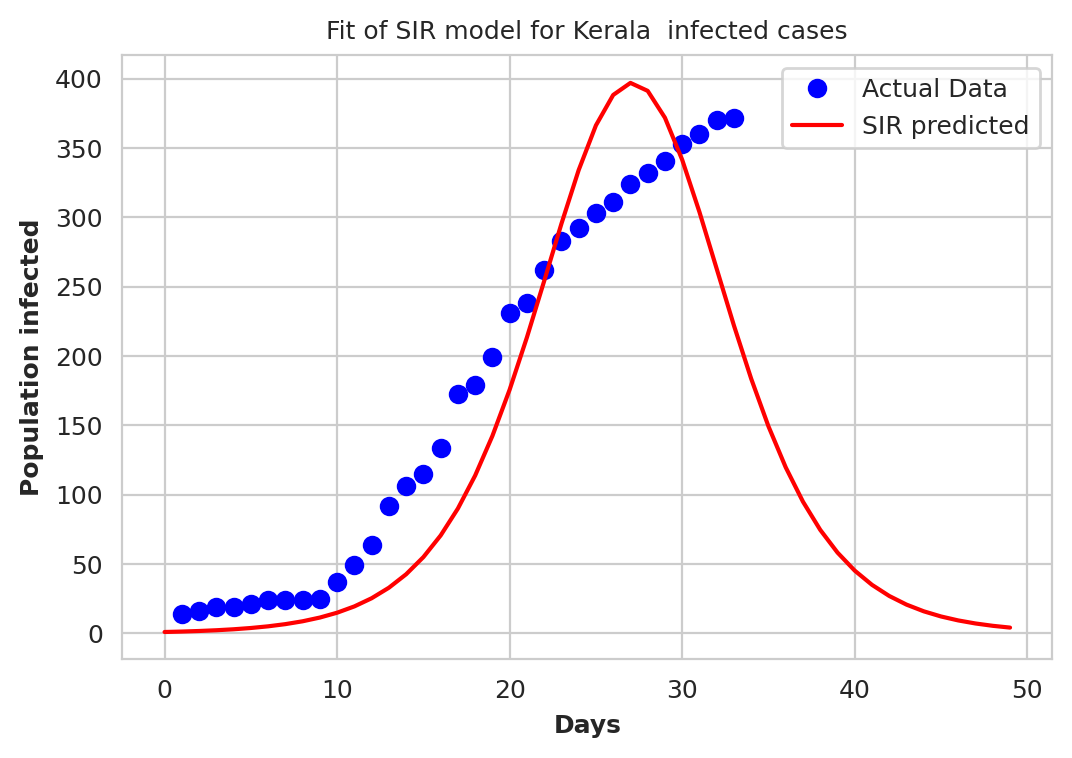

In [68]:
state='Kerala'
maxdays=50

population = pop_info[pop_info['Name']==state]['Population'].tolist()[0]
state_df = pd.DataFrame()
train=final_data
# state_df['ConfirmedCases'] = train.loc[train['State']==state].ConfirmedCases.diff().fillna(0)
state_df['ConfirmedCases'] = train.loc[train['State']==state].ConfirmedCases
state_df = state_df[10:]
state_df['day_count'] = list(range(1,len(state_df)+1))

ydata = state_df.ConfirmedCases
xdata = state_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = 1
sus0 = N - inf0
rec0 = 0.0

# b0 = 1
# beta = .03
# gamma = .02
# hs = 0.5

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)
xpred=np.arange(0,maxdays)
pred = fit_odeint(xpred, *popt)

plt.plot(xdata, ydata, 'bo', label='Actual Data')
plt.plot(xpred, pred, 'r-',label='SIR predicted')
plt.title("Fit of SIR model for "+ state +"  infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
plt.legend()

In [58]:
print(xdata)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.]
